In [51]:
# === Imports de base ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Machine learning ===
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# === Configuration des affichages ===
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [52]:
# Chargement des jeux de données
df_interaction = pd.read_csv("../data/raw/RAW_interactions.csv")
df_recipe = pd.read_csv("../data/raw/RAW_recipes.csv")

print("✅ Données chargées avec succès.")
print(df_interaction.shape)
df_interaction.head()


✅ Données chargées avec succès.
(1132367, 5)


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [53]:
# Agrégation par utilisateur
df_user = df_interaction.groupby("user_id").agg(
    nb_reviews=('rating', 'count'),
    mean_rating=('rating', 'mean'),
    std_rating=('rating', 'std')
).reset_index()

# Gestion des NaN (certains utilisateurs n'ont qu'une seule review donc std = NaN)
df_user['std_rating'] = df_user['std_rating'].fillna(0)

print("✅ Données agrégées par utilisateur :")
print(df_user.describe())


✅ Données agrégées par utilisateur :
            user_id     nb_reviews    mean_rating     std_rating
count  2.265700e+05  226570.000000  226570.000000  226570.000000
mean   5.948661e+08       4.997868       3.873031       0.218623
std    9.017845e+08      49.663111       1.773173       0.619201
min    1.533000e+03       1.000000       0.000000       0.000000
25%    5.534592e+05       1.000000       3.800000       0.000000
50%    1.579232e+06       1.000000       5.000000       0.000000
75%    1.803517e+09       2.000000       5.000000       0.000000
max    2.002373e+09    7671.000000       5.000000       3.535534


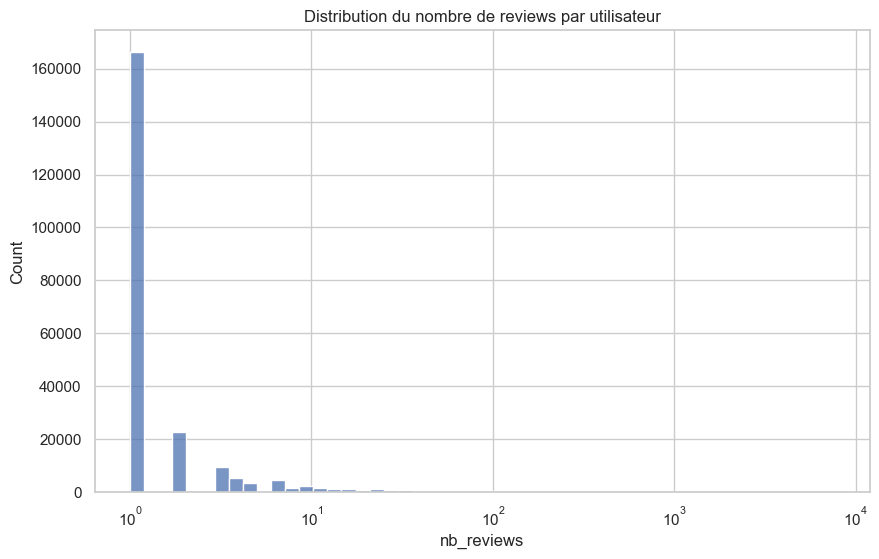

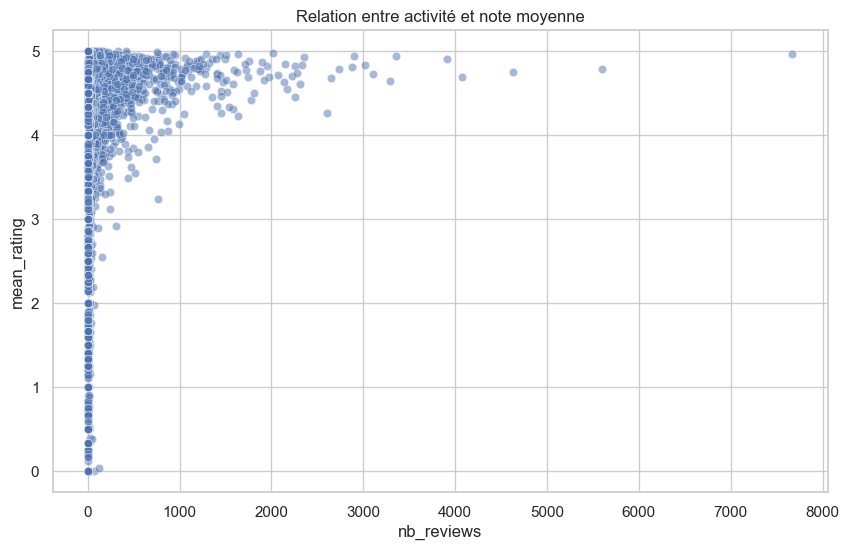

In [54]:
sns.histplot(df_user['nb_reviews'], bins=50, log_scale=(True, False))
plt.title("Distribution du nombre de reviews par utilisateur")
plt.show()

sns.scatterplot(data=df_user, x="nb_reviews", y="mean_rating", alpha=0.5)
plt.title("Relation entre activité et note moyenne")
plt.show()


In [55]:
features = ["nb_reviews", "mean_rating", "std_rating"]
X = df_user[features]

# Transformation logarithmique sur nb_reviews (évite les valeurs extrêmes)
X["nb_reviews"] = np.log1p(X["nb_reviews"])

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


/var/folders/73/zx24sp5s3sn2p2j35t94kt6h0000gn/T/ipykernel_77152/3170003665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["nb_reviews"] = np.log1p(X["nb_reviews"])


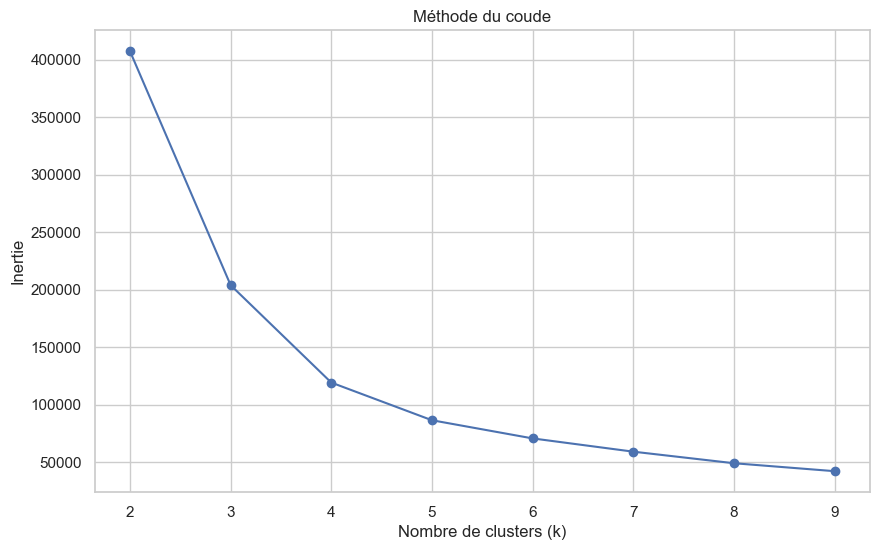

In [56]:
inertias = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title("Méthode du coude")
plt.show()


The elbow method helps us to find the optimal number of clusters.

In [57]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_user["cluster"] = kmeans.fit_predict(X_scaled)

print("✅ Clustering terminé.")
df_user["cluster"].value_counts()


✅ Clustering terminé.


cluster
1    157674
2     40445
0     16120
3     12331
Name: count, dtype: int64

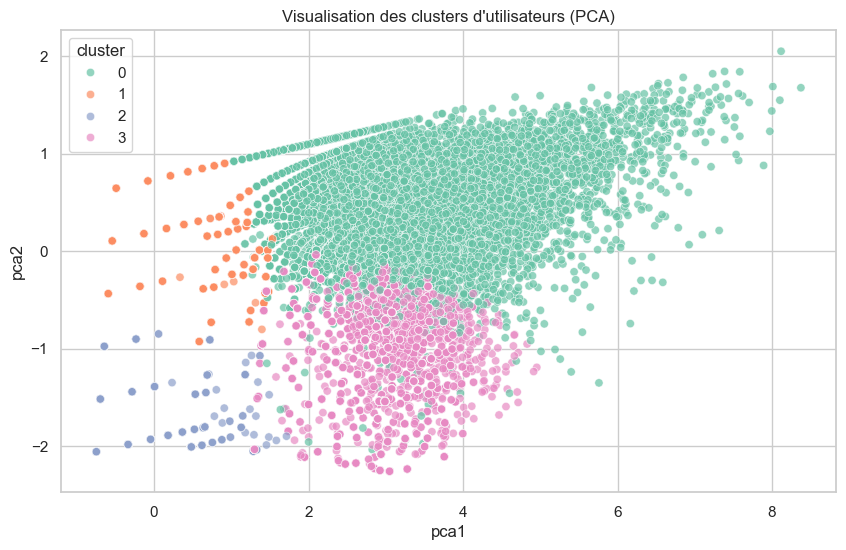

In [58]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_user["pca1"] = X_pca[:, 0]
df_user["pca2"] = X_pca[:, 1]

sns.scatterplot(
    data=df_user, x="pca1", y="pca2",
    hue="cluster", palette="Set2", alpha=0.7
)
plt.title("Visualisation des clusters d'utilisateurs (PCA)")
plt.show()


In [59]:
cluster_summary = df_user.groupby("cluster")[features].mean().round(2)
cluster_summary["effectif"] = df_user["cluster"].value_counts()
cluster_summary


,nb_reviews,mean_rating,std_rating,effectif
cluster,,,,
0,51.35,4.53,0.81,16120
1,1.36,4.77,0.04,157674
2,1.04,0.33,0.00,40445
3,3.87,3.11,2.43,12331
